In [1]:
from pytorch_gradient_boosting import PyTorchGradientBoosting
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, log_loss
from sklearn.model_selection import train_test_split

In [2]:
data = pd.read_csv("../data/HR.csv")
data = data.rename(columns={"sales": "department"})
data = pd.get_dummies(data)
categorical = ['department_IT', 'department_RandD', 'department_accounting', 'department_hr', 
                'department_management', 'department_marketing', 'department_product_mng', 
                'department_sales', 'department_support', 'department_technical', 
                'salary_high', 'salary_low', 'salary_medium']
data[categorical] = data[categorical].astype(float)

y = data['left']
X = data.drop(columns=['left'])
feature_names = X.columns.tolist()

# Split the data
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.2, random_state=42, stratify=y_train_val)

print("Training set size:", X_train.shape[0])
print("Validation set size:", X_val.shape[0])
print("Test set size:", X_test.shape[0])

Training set size: 9599
Validation set size: 2400
Test set size: 3000


In [3]:
# Initialize and train the model
model = PyTorchGradientBoosting(
    n_estimators=500,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    random_state=42,
    reg_lambda=1.0,
    reg_alpha=0.1,
    class_weight='balanced'
)

# Train the model with early stopping
model.fit(
    X_train.values, 
    y_train.values,
    eval_set=(X_val.values, y_val.values),
    early_stopping_rounds=50,
    verbose=True
)


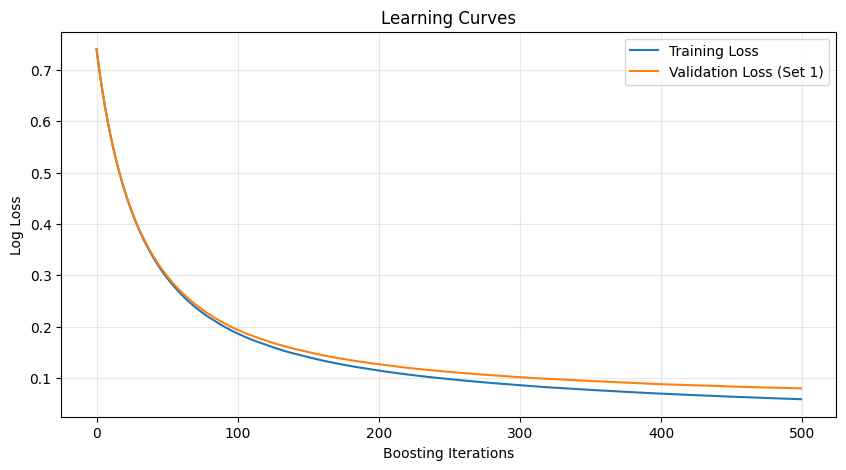

In [4]:
model.plot_learning_curve()

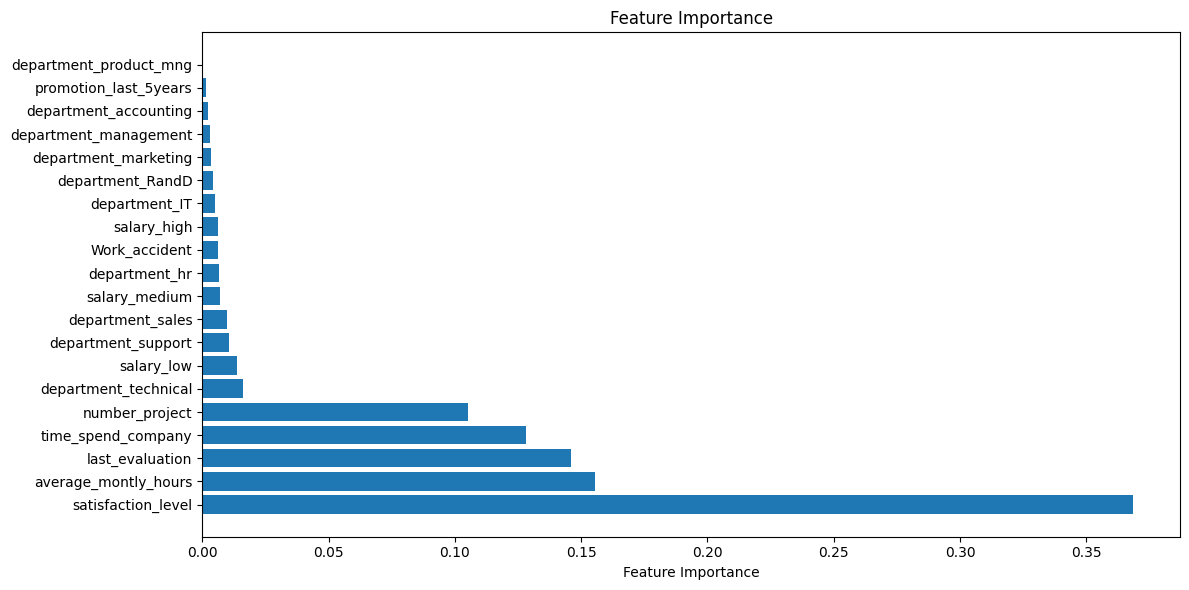

In [5]:
model.plot_feature_importance(feature_names)

In [6]:
# Make predictions on test set
y_pred_proba = model.predict_proba(X_test.values)
y_pred = model.predict(X_test.values)

# Convert PyTorch tensors to numpy for scikit-learn metrics
y_pred_proba_np = y_pred_proba.cpu().numpy()
y_pred_np = y_pred.cpu().numpy()

# Evaluate model
print("\nTest Set Evaluation:")
print(f"AUC: {roc_auc_score(y_test, y_pred_proba_np):.4f}")
print(f"Accuracy: {accuracy_score(y_test, y_pred_np):.4f}")
print(f"Log Loss: {log_loss(y_test, y_pred_proba_np):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_np):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_np):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_np):.4f}")


Test Set Evaluation:
AUC: 0.9931
Accuracy: 0.9843
Log Loss: 0.0842
Precision: 0.9704
Recall: 0.9636
F1 Score: 0.9670


In [7]:
best_threshold, best_score, threshold_metrics = model.calibrate_threshold(X_val.values, y_val.values, metric='f1')
print(f"\nBest threshold: {best_threshold:.4f}")
print(f"Best f1 score: {best_score:.4f}")
final_preds = (y_pred_proba_np >= best_threshold).astype(int)
print(f"Final accuracy with best threshold: {accuracy_score(y_test, final_preds):.4f}")


Best threshold: 0.6300
Best f1 score: 0.9696
Final accuracy with best threshold: 0.9833


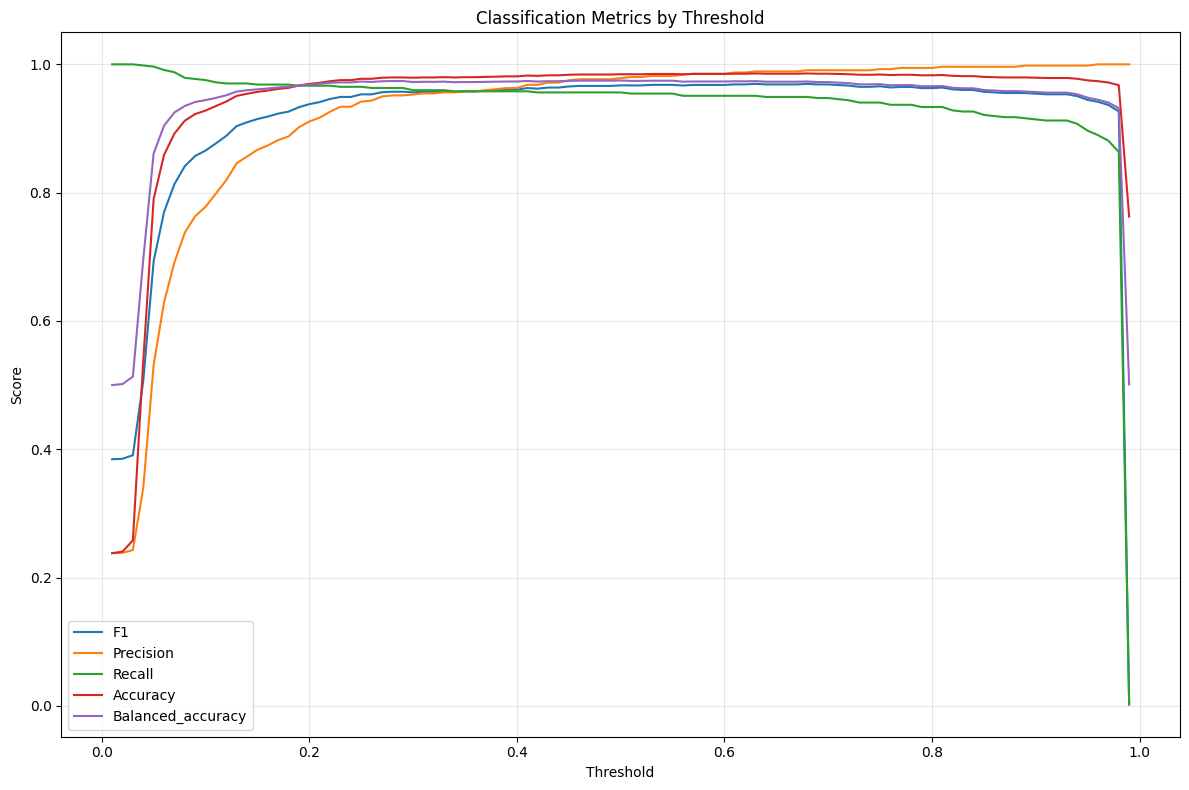

In [8]:
model.plot_threshold_metrics(threshold_metrics) 

In [9]:
model.save_model("xgboost.pth")


Model saved to xgboost.pth.pkl
